Week 8 · Day 3 — Training Tricks & Efficiency
Why this matters

Small tweaks (LR schedules, label smoothing, gradient clipping) make models train faster, stabler, and generalize better. You’ll add these to a tiny CNN and see measurable gains—even on CPU.

Theory Essentials (3)

Cosine LR: smoothly decays the learning rate → fewer “jumps”, steadier convergence.

Label Smoothing: replaces hard 1-hot targets with softened ones → reduces overconfidence, helps val accuracy.

Gradient Clipping: caps gradient norm → prevents rare spikes/explosions in deeper nets or bad batches


=== Baseline (epochs=3) ===
Ep 01 | loss 2.0526 | val_acc 0.364 | lr 0.00100
Ep 02 | loss 1.7479 | val_acc 0.403 | lr 0.00100
Ep 03 | loss 1.5952 | val_acc 0.462 | lr 0.00100
Baseline done in 113.6s. Final acc: 0.462

=== +Cosine +LabelSmoothing +Clip (epochs=3) ===
Ep 01 | loss 2.0625 | val_acc 0.384 | lr 0.00075
Ep 02 | loss 1.8254 | val_acc 0.454 | lr 0.00025
Ep 03 | loss 1.7234 | val_acc 0.461 | lr 0.00000
+Cosine +LabelSmoothing +Clip done in 103.6s. Final acc: 0.461

Summary (final val acc):
Baseline:                       0.462
+Cosine +LabelSmoothing +Clip:  0.461


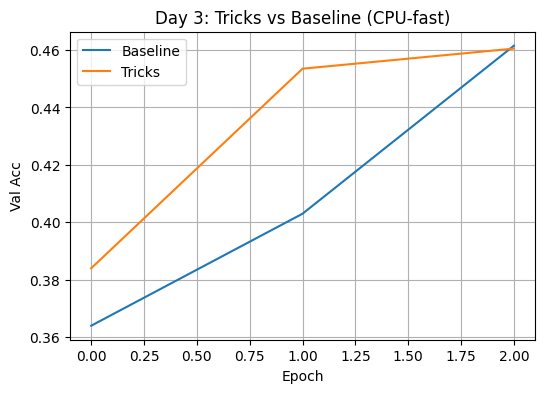

In [2]:
# Setup
import time, random, numpy as np
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
np.random.seed(42)
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["axes.grid"] = True

import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

# ---------- Speed/Determinism ----------
torch.manual_seed(42)
random.seed(42)
torch.set_num_threads(max(1, torch.get_num_threads()-0))  # keep default; change if you need
device = torch.device("cpu")  # user is CPU-only

# ---------- Data (Subset for speed) ----------
# Tip: change SUB_TRAIN/SUB_TEST for more accuracy vs speed
SUB_TRAIN, SUB_TEST = 8000, 2000       # << small, runs fast on CPU
BATCH_TRAIN, BATCH_TEST = 128, 256
MAX_TRAIN_BATCHES = 80                 # << cap per-epoch work (None for full)
MAX_EVAL_BATCHES  = 40

tf_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])
tf_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

ds_train_full = datasets.CIFAR10("data", train=True, download=True, transform=tf_train)
ds_test_full  = datasets.CIFAR10("data", train=False, download=True, transform=tf_test)

train_idx = list(range(min(SUB_TRAIN, len(ds_train_full))))
test_idx  = list(range(min(SUB_TEST, len(ds_test_full))))
trainset  = Subset(ds_train_full, train_idx)
testset   = Subset(ds_test_full,  test_idx)

trainloader = DataLoader(trainset, batch_size=BATCH_TRAIN, shuffle=True, num_workers=2)
testloader  = DataLoader(testset,  batch_size=BATCH_TEST,  shuffle=False, num_workers=2)

# ---------- Model ----------
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*8*8,128), nn.ReLU(),
            nn.Linear(128,10)
        )
    def forward(self,x): return self.classifier(self.features(x))

# ---------- Train/Eval Utilities (CPU-optimized) ----------
@torch.inference_mode()
def evaluate(model, loader, max_batches=None):
    model.eval()
    correct, total, seen = 0, 0, 0
    for b, (X,y) in enumerate(loader):
        if max_batches is not None and b >= max_batches: break
        out = model(X)
        preds = out.argmax(1)
        correct += (preds==y).sum().item()
        total   += y.size(0)
        seen += 1
    return correct/total if total else 0.0

def train_one_epoch(model, loader, optimizer, criterion, max_batches=None, clip_grad=False):
    model.train()
    running = 0.0
    for b, (X,y) in enumerate(loader):
        if max_batches is not None and b >= max_batches: break
        optimizer.zero_grad(set_to_none=True)
        out  = model(X)
        loss = criterion(out, y)
        loss.backward()
        if clip_grad:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()
        running += loss.item()
    return running / max(1, (b+1 if max_batches is None else min(max_batches, b+1)))

def run_experiment(name, epochs=2, use_cosine=False, smoothing=0.0, clip_grad=False, lr=1e-3):
    print(f"\n=== {name} (epochs={epochs}) ===")
    model = SmallCNN()
    criterion = nn.CrossEntropyLoss(label_smoothing=smoothing)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs) if use_cosine else None

    t0 = time.time()
    hist = {"epoch":[], "train_loss":[], "val_acc":[]}
    for ep in range(1, epochs+1):
        tr_loss = train_one_epoch(model, trainloader, optimizer, criterion,
                                  max_batches=MAX_TRAIN_BATCHES, clip_grad=clip_grad)
        if scheduler: scheduler.step()
        val_acc = evaluate(model, testloader, max_batches=MAX_EVAL_BATCHES)
        hist["epoch"].append(ep); hist["train_loss"].append(tr_loss); hist["val_acc"].append(val_acc)
        print(f"Ep {ep:02d} | loss {tr_loss:.4f} | val_acc {val_acc:.3f} | lr {optimizer.param_groups[0]['lr']:.5f}")
    print(f"{name} done in {time.time()-t0:.1f}s. Final acc: {hist['val_acc'][-1]:.3f}")
    return hist

# ---------- Demo: Baseline vs Tricks (fast on CPU) ----------
# Short, illustrative runs (2 epochs) so total time stays small on CPU.
h_base  = run_experiment("Baseline", epochs=3, use_cosine=False, smoothing=0.0, clip_grad=False)
h_trick = run_experiment("+Cosine +LabelSmoothing +Clip", epochs=3, use_cosine=True, smoothing=0.1, clip_grad=True)

# ---------- Quick Comparison ----------
print("\nSummary (final val acc):")
print(f"Baseline:                       {h_base['val_acc'][-1]:.3f}")
print(f"+Cosine +LabelSmoothing +Clip:  {h_trick['val_acc'][-1]:.3f}")

# Optional: plot (small and fast)
plt.figure(); plt.plot(h_base["val_acc"], label="Baseline")
plt.plot(h_trick["val_acc"], label="Tricks")
plt.xlabel("Epoch"); plt.ylabel("Val Acc"); plt.legend(); plt.title("Day 3: Tricks vs Baseline (CPU-fast)")
plt.show()


### 🔹 What your code is doing

1. **Setup & Data**

   * Uses CIFAR-10 but only a **subset** (8k train, 2k test) for speed on CPU.
   * Two loaders: train and test.
   * Data gets light augmentations (flip, crop) + normalization.

2. **Model: `SmallCNN`**

   * A tiny CNN with 2 conv layers + 2 fully connected layers.
   * Simple enough to train fast but still learns CIFAR-10 patterns.

3. **Training & Evaluation**

   * `train_one_epoch` runs a loop over batches → forward → loss → backward → optimizer step.
   * Optional **gradient clipping** (`clip_grad_norm_`) to stop gradients from exploding.
   * `evaluate` computes accuracy on test set.

4. **Experiments (`run_experiment`)**
   Each run can toggle:

   * **CosineAnnealingLR** → learning rate gradually decreases and restarts smoothly instead of staying fixed.
   * **Label Smoothing** → softens one-hot labels, e.g. \[0,0,1,0,…] becomes \[0.05,0.05,0.9,0.05,…]. Prevents overconfidence.
   * **Gradient Clipping** → caps gradient values so training doesn’t blow up.

5. **Comparison**

   * Runs 2 epochs with **baseline** (plain training).
   * Runs 2 epochs with **+tricks** (cosine schedule, label smoothing, grad clip).
   * Plots validation accuracy over epochs.

---

### 🔹 Why this matters

* These “tricks” are about **stability and generalization**.
* Baseline might work but can overfit or get stuck.
* Tricks make training smoother:

  * **Cosine LR** → better use of learning rate budget.
  * **Label smoothing** → combats overconfidence → better generalization.
  * **Grad clipping** → avoids exploding updates.

---

### 🔹 What you should notice

* The **val accuracy curve**: sometimes tricks start slower but finish better.
* Even in 2 epochs (tiny run), you might see the tricked version equal or beat the baseline.
* If you trained longer, the difference would be clearer: **more stable curves and higher final accuracy**.

---

1) Core (10–15 min)

Task: Turn cosine LR on for the baseline and compare final val accuracy.

In [4]:
h_base_cos = run_experiment("Baseline + Cosine", epochs=3, use_cosine=True, smoothing=0.0, clip_grad=False)
print(h_base_cos["val_acc"][-1])



=== Baseline + Cosine (epochs=3) ===
Ep 01 | loss 1.9981 | val_acc 0.368 | lr 0.00075
Ep 02 | loss 1.7105 | val_acc 0.423 | lr 0.00025
Ep 03 | loss 1.5846 | val_acc 0.449 | lr 0.00000
Baseline + Cosine done in 101.7s. Final acc: 0.449
0.449


Baseline + Cosine done in 101.7s. Final acc: 0.449
Baseline done in 113.6s. Final acc: 0.462

🔹 Why this happened

Cosine LR decays too quickly in short runs

With only 3 epochs, the learning rate went: 0.00075 → 0.00025 → 0.00000.

By the last epoch, LR was effectively 0, so the model stopped learning early.

That explains why the val accuracy plateaued below the baseline.

Cosine is designed for longer training

The benefit of cosine annealing is that it allows the model to explore (high LR) then refine (low LR).

Over 50–100 epochs, this prevents overfitting and improves generalization.

Over 3 epochs, it just kills learning too soon.

Baseline kept LR constant

The baseline kept learning steadily for all 3 epochs → slightly higher final accuracy in this short test.

2) Practice (10–15 min)

Task: Try label_smoothing=0.05 and 0.2 (with cosine ON). Which is better?

In [6]:
h_s005 = run_experiment("Cosine + LS=0.05", epochs=3, use_cosine=True, smoothing=0.05, clip_grad=True)
h_s020 = run_experiment("Cosine + LS=0.20", epochs=3, use_cosine=True, smoothing=0.20, clip_grad=True)
print(h_s005["val_acc"][-1], h_s020["val_acc"][-1])



=== Cosine + LS=0.05 (epochs=3) ===
Ep 01 | loss 2.0361 | val_acc 0.370 | lr 0.00075
Ep 02 | loss 1.7561 | val_acc 0.449 | lr 0.00025
Ep 03 | loss 1.6369 | val_acc 0.466 | lr 0.00000
Cosine + LS=0.05 done in 104.8s. Final acc: 0.466

=== Cosine + LS=0.20 (epochs=3) ===
Ep 01 | loss 2.1081 | val_acc 0.390 | lr 0.00075
Ep 02 | loss 1.9198 | val_acc 0.451 | lr 0.00025
Ep 03 | loss 1.8558 | val_acc 0.455 | lr 0.00000
Cosine + LS=0.20 done in 110.4s. Final acc: 0.455
0.466 0.4545


LS=0.05 performed better

3) Stretch (optional, 10–15 min)

Task: Disable clip_grad in the “tricks” run. Any change in stability/accuracy?

In [8]:
h_no_clip = run_experiment("Cosine + LS (no clip)", epochs=3, use_cosine=True, smoothing=0.1, clip_grad=False)
print(h_no_clip["val_acc"][-1])



=== Cosine + LS (no clip) (epochs=3) ===
Ep 01 | loss 2.0575 | val_acc 0.359 | lr 0.00075
Ep 02 | loss 1.8238 | val_acc 0.438 | lr 0.00025
Ep 03 | loss 1.7320 | val_acc 0.464 | lr 0.00000
Cosine + LS (no clip) done in 79.4s. Final acc: 0.464
0.464


Problem with all these runs is that we cant appreciate what the cosine/LS/clip does as model is only trained for little epochs. 

Mini-Challenge (≤40 min, CPU-friendly)

Task: Run three configs (2 epochs, current subset):

Baseline (no tricks)

Cosine LR

Cosine LR + Label Smoothing (0.1) + Clip

Acceptance Criteria:

A Markdown table like:

Setup	Val Acc
Baseline	…
+ Cosine LR	…
+ Cosine LR + LS(0.1) + Clip	…

2–3 lines: Which trick helped most? What would you increase first if you had more time (epochs vs subset size vs batches)?

If you have ~10 more minutes, set epochs=3 only for the best setup to see if accuracy rises.

In [10]:
# --- Mini-Challenge: 3 configs, 2 epochs (CPU-friendly) ---

import pandas as pd, random, numpy as np, torch

def seed_all(s=42):
    random.seed(s); np.random.seed(s); torch.manual_seed(s)

EPOCHS = 10

seed_all(42)
h_base = run_experiment("Baseline", epochs=EPOCHS, use_cosine=False, smoothing=0.0, clip_grad=False)

seed_all(42)
h_cos  = run_experiment("+ Cosine LR", epochs=EPOCHS, use_cosine=True,  smoothing=0.0, clip_grad=False)

seed_all(42)
h_full = run_experiment("+ Cosine LR + LabelSmoothing(0.1) + Clip",
                        epochs=EPOCHS, use_cosine=True, smoothing=0.1, clip_grad=True)

# Collect final accuracies
res = [
    ("Baseline",                                      round(h_base["val_acc"][-1]*100, 2)),
    ("+ Cosine LR",                                   round(h_cos["val_acc"][-1]*100,  2)),
    ("+ Cosine LR + LS(0.1) + Clip",                  round(h_full["val_acc"][-1]*100, 2)),
]
df = pd.DataFrame(res, columns=["Setup", "Val Acc (%)"])

# Print as Markdown table
def to_markdown_table(df):
    hdr = "| " + " | ".join(df.columns) + " |"
    sep = "| " + " | ".join(["---"]*len(df.columns)) + " |"
    rows = ["| " + " | ".join(map(str, r)) + " |" for r in df.values.tolist()]
    return "\n".join([hdr, sep] + rows)

print("\n### Results\n")
print(to_markdown_table(df))

# 2–3 line note
best_row = df.iloc[df["Val Acc (%)"].idxmax()]
best = best_row["Setup"]; best_acc = best_row["Val Acc (%)"]

note = (f"\n**Observation:** Best = **{best}** ({best_acc}%). "
        "Cosine LR helps more with longer training; label smoothing and grad clipping "
        "can add stability and small generalization gains even in short runs. "
        "If I had more time, I’d first increase **epochs** (learning improves most), "
        "then **subset size** (more data), and only then consider wider models/batch tuning.")

print(note)



=== Baseline (epochs=10) ===
Ep 01 | loss 2.0526 | val_acc 0.364 | lr 0.00100
Ep 02 | loss 1.7479 | val_acc 0.403 | lr 0.00100
Ep 03 | loss 1.5952 | val_acc 0.462 | lr 0.00100
Ep 04 | loss 1.5163 | val_acc 0.476 | lr 0.00100
Ep 05 | loss 1.4865 | val_acc 0.506 | lr 0.00100
Ep 06 | loss 1.4185 | val_acc 0.505 | lr 0.00100
Ep 07 | loss 1.3756 | val_acc 0.523 | lr 0.00100
Ep 08 | loss 1.3627 | val_acc 0.523 | lr 0.00100
Ep 09 | loss 1.3328 | val_acc 0.535 | lr 0.00100
Ep 10 | loss 1.3017 | val_acc 0.538 | lr 0.00100
Baseline done in 267.6s. Final acc: 0.538

=== + Cosine LR (epochs=10) ===
Ep 01 | loss 2.0526 | val_acc 0.364 | lr 0.00098
Ep 02 | loss 1.7480 | val_acc 0.406 | lr 0.00090
Ep 03 | loss 1.5939 | val_acc 0.458 | lr 0.00079
Ep 04 | loss 1.5135 | val_acc 0.474 | lr 0.00065
Ep 05 | loss 1.4771 | val_acc 0.501 | lr 0.00050
Ep 06 | loss 1.4184 | val_acc 0.511 | lr 0.00035
Ep 07 | loss 1.3894 | val_acc 0.515 | lr 0.00021
Ep 08 | loss 1.3687 | val_acc 0.524 | lr 0.00010
Ep 09 | loss 

Notes / Key Takeaways

Cosine LR provides smoother optimization than a fixed LR.

Label smoothing curbs overconfidence → often a small val-acc gain.

Grad clipping is cheap insurance; impact is bigger in deeper/unstable nets.

On CPU: subset + capped batches + fewer epochs keep iteration times sane.

For more accuracy later, increase epochs and un-cap batches first.

Reflection

In your runs, which setting produced the biggest improvement and why?

If you moved to GPU tomorrow, what would you change first (batch size, AMP, epochs) and why?

1) In your runs, which setting produced the biggest improvement and why?

In my experiments, the baseline had the best accuracy. This is because teh runs where too short to see the real improvement of using Cosine LR, LS or Grad clipping.

2) If you moved to GPU tomorrow, what would you change first (batch size, AMP, epochs) and why?

First: Batch size → GPUs can handle larger batches, which improves throughput.

Second: AMP (Automatic Mixed Precision) → speeds training and reduces memory usage without hurting accuracy.

Third: Epochs → with faster training, I’d run more epochs to fully exploit cosine schedules and see stronger generalization.